This notebook shows how to apply CNN to predict the global temperature map, based on the 1-D time series of CO2 & CH4.

By Weiwei Zhan & Francesco Immorlano

In [1]:
!pip install tensorflow

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

print(train_path)

gs://leap-persistent/jbusecke/data/climatebench/train_val/


### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

Here we train CNN using simulations from 3 historical and 3 future scenarios. Then we test the trained NN using the ssp245 scenario.

In [5]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### select relevant variables

predictors: CO2 & CH4 <br/>
predictand: tas

In [6]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)

y_train = y_train_xr['tas'].data
y_test  = y_test_xr['tas'].data



This is how our predictors & predictand data look like. Our predictors are **1-D** time series of CO2 & CH4.

In [7]:
X_train_df.head()

,CO2,CH4
0,0.188297,0.031306
1,0.377244,0.031742
2,0.573814,0.032178
3,0.778848,0.032614
4,1.020320,0.033049


The predictand tas is **2-D** map - this point is different from the NN case

In [8]:
# Normally, you will have one data set on a specific time range (daily)
# The data set will have your predictor variables (the variables that affect your response variable).
# One the same dataset (or a different dataset but within the same time range), you will have your 
# variable, which they call predictand
# The response variable is the variable of which you are interesested in projecting.

# So, of instance in this example, let's say you have daily CO2 emission and CH4 emission values from 
# 1900 to 2020
# Then you have a datset of air temperature from 1900 to 2020

# You will divide the dataset into 80-20 ratio.

# So for example, your training data set of predictors will have CO2 and CH4 emissions from 1900
# to 1990, and your testing would have CO2 and CH4 emissions from 1991 to 2021
# Likewise, your training data for the response (air temperature) would be from 1900 to 1990,
# with the testing from 1991 to 2021

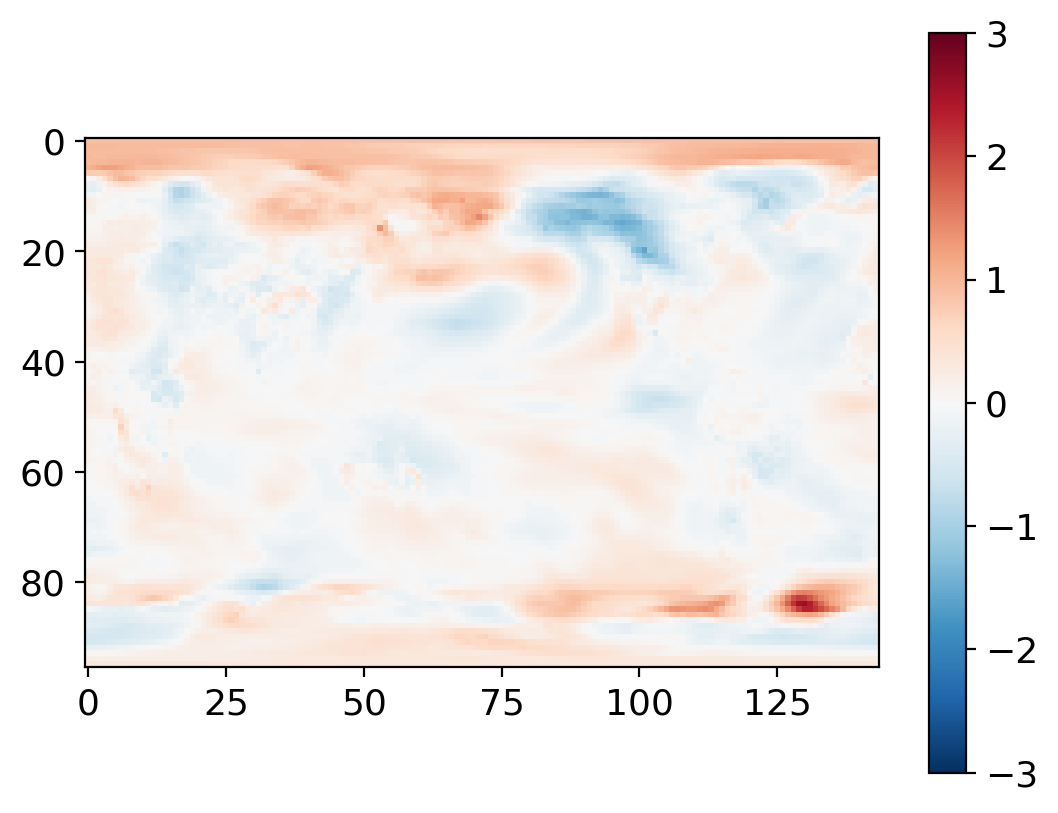

In [9]:
plt.imshow(np.flip(y_train[0],axis=0),cmap='RdBu_r',vmin=-3,vmax=3)
plt.colorbar()

#### Data normalization

Let's normalize the input predictors by there mean & standard deviation

In [10]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

In [11]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(753, 2) (753, 96, 144) (86, 2) (86, 96, 144)


### 2. Define the CNN architecture


The CNN architecture used here consists of several upsampling blocks. 

We set the dimensions of the hidden layers (i.e., number of neurons) in order to reach the size of the target maps (96x144) in a proportional way (in particular by doubling the dimensions in each upsampling block) through the various upsampling blocks. 

![CNN_structure](https://drive.google.com/uc?export=view&id=18a4aKFf62qWgFZP57HloHKrzHdZpmqjO)

Here are the hyperparameters for the CNN training. Note that these hyperparameters here are for demonstration purposes only and they are not optimized.  

In [12]:
n_filters  = 32  # number of filters (kernels)
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 4
learning_rate  = 0.001
minibatch_size = 64
num_epochs     = 100


In [13]:
model = Sequential()

model.add(Dense(n_filters*12*18, input_shape=(X_train.shape[1],), activation=activation)) # shape: (6912,1)
model.add(Reshape((12,18,n_filters))) # shape: (12,18,32)

# Upsample to 24x36
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (24,36,32)

# Upsample to 48x72
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (48,72,32)

# Upsample to 96x144
model.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (96,144,32)

model.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation="linear", padding="same")) # shape: (96,144,1)


model.summary()
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6912)              20736     
                                                                 
 reshape (Reshape)           (None, 12, 18, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 24, 36, 32)       16416     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 48, 72, 32)       16416     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 96, 144, 32)      16416     
 ranspose)                                                       
                                                        

2023-06-14 13:44:35.725369: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/nvidia/lib64
2023-06-14 13:44:35.725403: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


### 3. Train & save the CNN model

In [15]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop]
                   )




Epoch 1/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3598 - val_loss: 0.5939
Epoch 2/100
10/10 [==============================] - 3s 258ms/step - loss: 0.3612 - val_loss: 0.5917
Epoch 3/100
10/10 [==============================] - 3s 260ms/step - loss: 0.3530 - val_loss: 0.5890
Epoch 4/100
10/10 [==============================] - 3s 261ms/step - loss: 0.3507 - val_loss: 0.5907
Epoch 5/100
10/10 [==============================] - 3s 259ms/step - loss: 0.3484 - val_loss: 0.5864
Epoch 6/100
10/10 [==============================] - 3s 260ms/step - loss: 0.3477 - val_loss: 0.5884
Epoch 7/100
10/10 [==============================] - 3s 260ms/step - loss: 0.3483 - val_loss: 0.5914
Epoch 8/100
10/10 [==============================] - 3s 260ms/step - loss: 0.3456 - val_loss: 0.5775
Epoch 9/100
10/10 [==============================] - 3s 257ms/step - loss: 0.3448 - val_loss: 0.5903
Epoch 10/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3462 - val_lo

KeyboardInterrupt: 

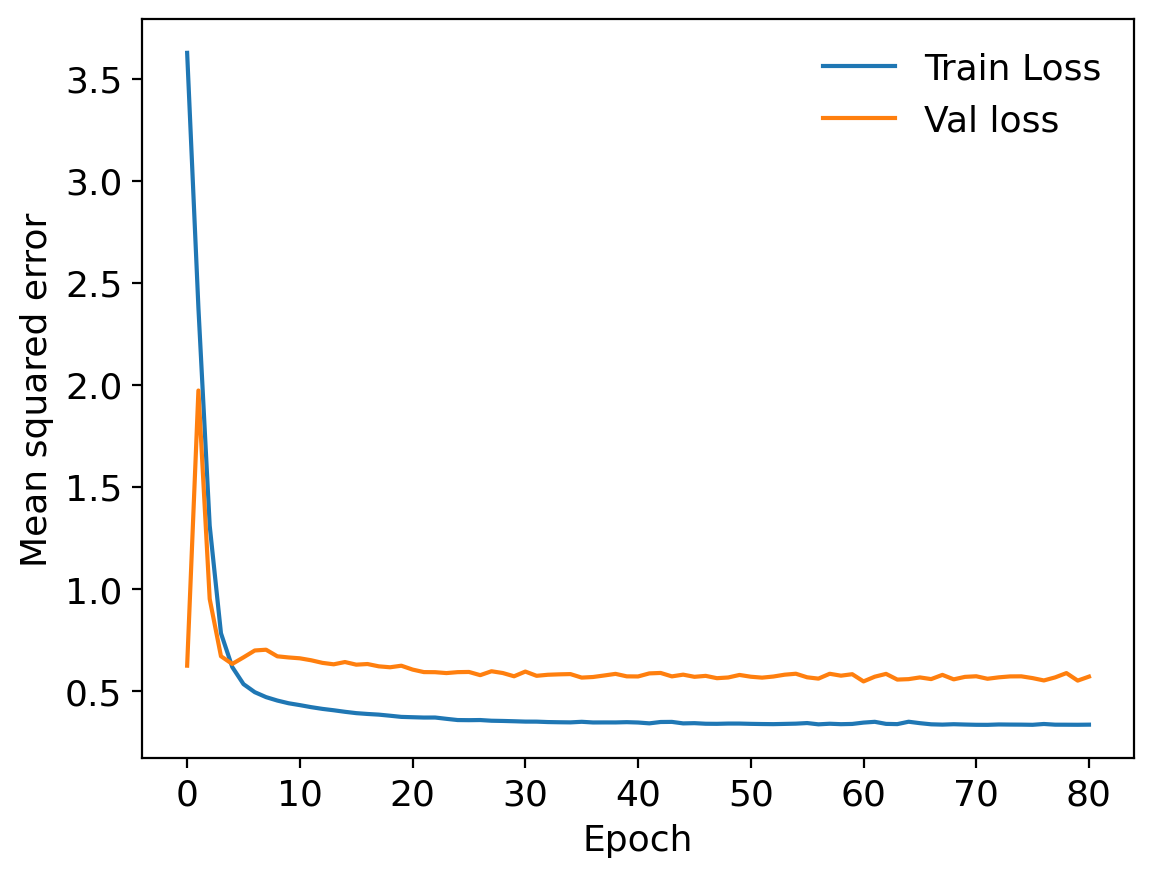

In [14]:
plot_history(history)

In [17]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [18]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(os.path.join(model_path,'CNN_model.h5'))

### 4. Evaluate the trained model

In [19]:
# reload the saved model
model = load_model(os.path.join(model_path,'CNN_model.h5'))

In [20]:
y_test_pre = model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)
y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

3/3 [==============================] - 0s 49ms/step


First we check whether the ML model can capture the spatial distribution of global temperature

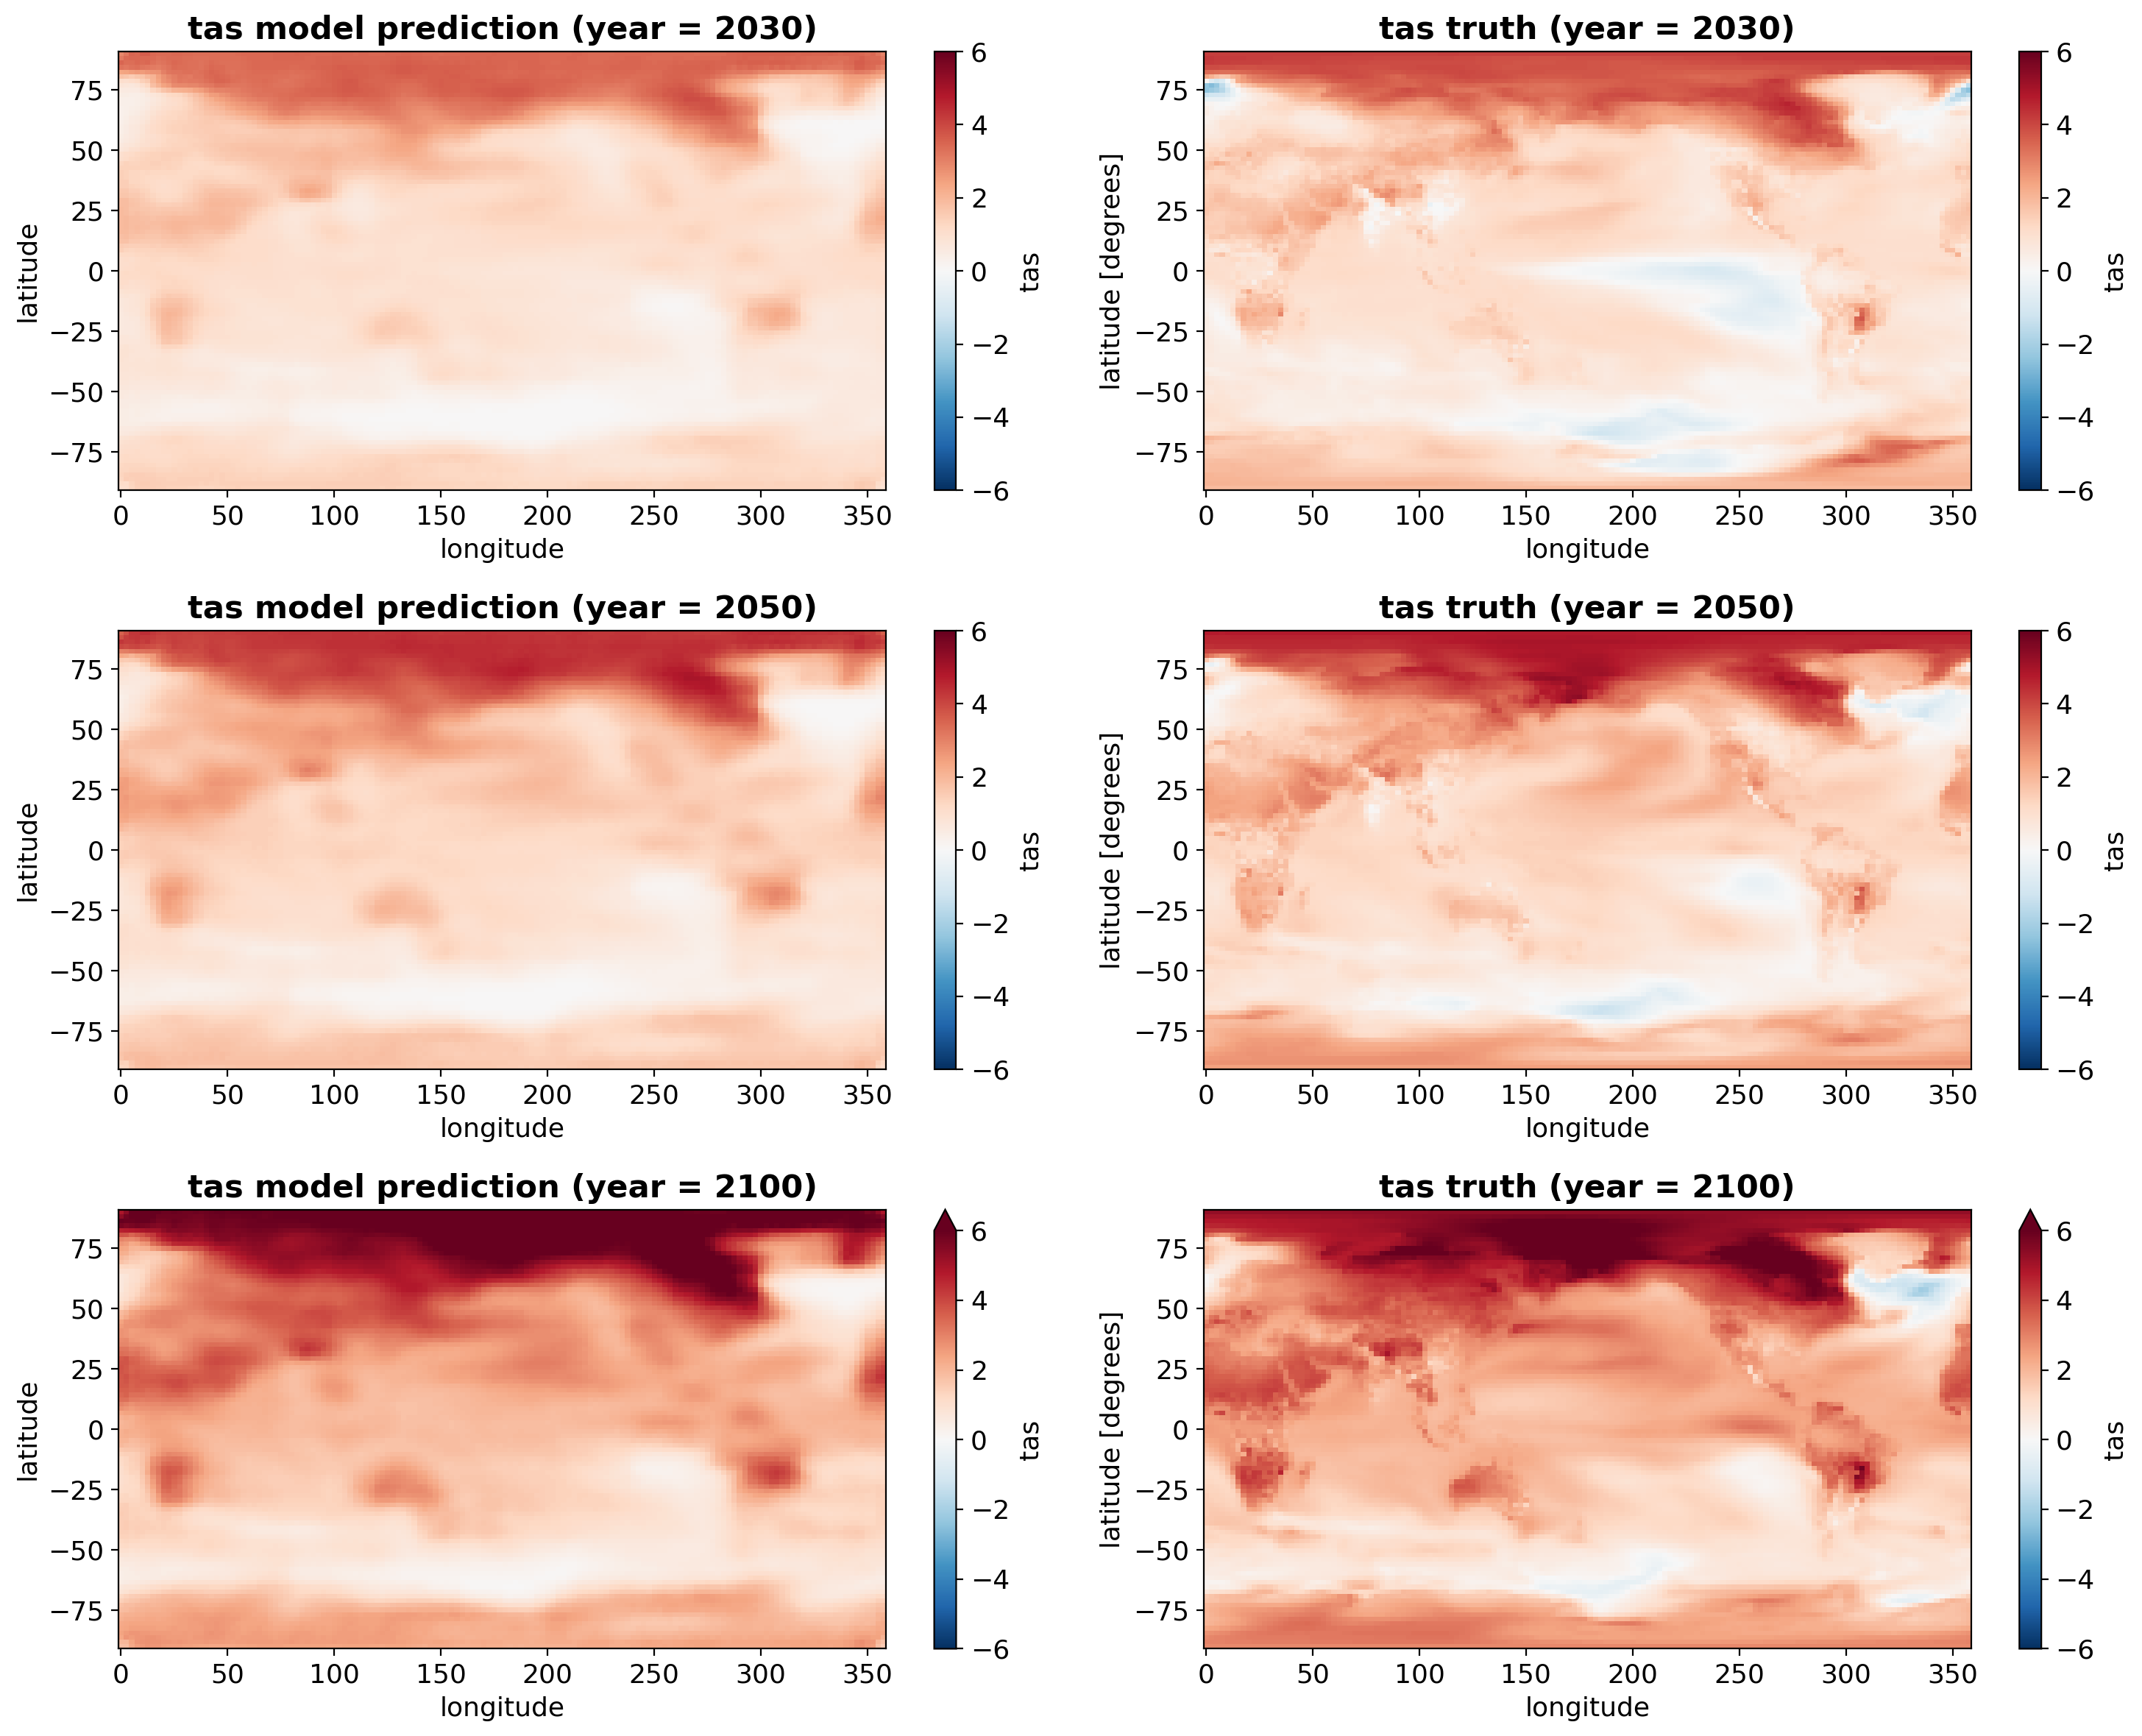

In [21]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

Text(0, 0.5, 'temperature (°C)')

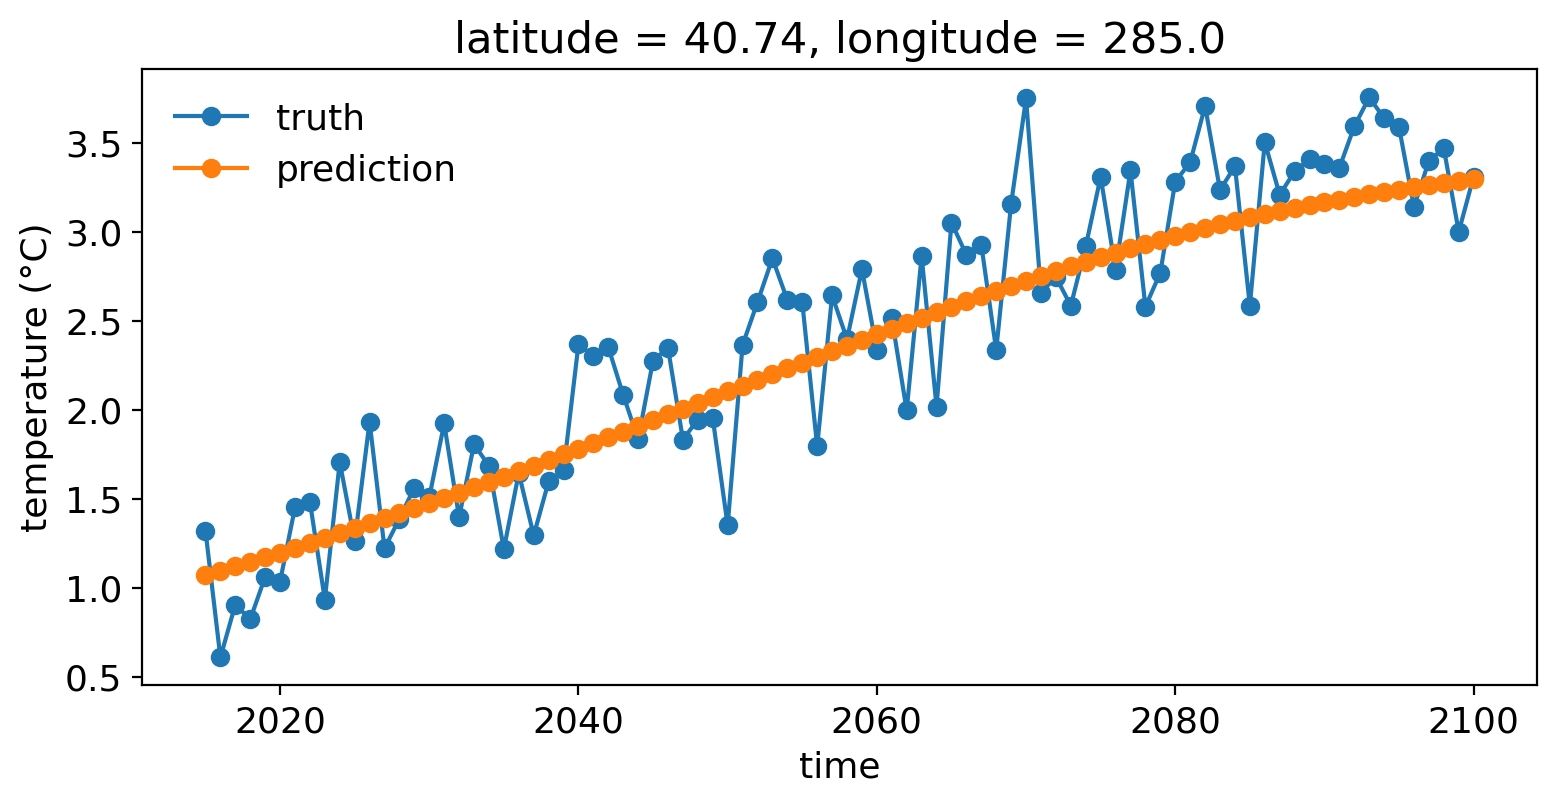

In [22]:
lat = 40.7128
lon = -74.0060%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='truth')
y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='prediction')

ax.legend()
ax.set_ylabel('temperature (°C)')

Finally we check whether the ML model can capture the time series of global average temperature 

In [23]:
def global_mean_std_plot(X,label,color,ax,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    tas_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, tas_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=color,alpha=0.2)

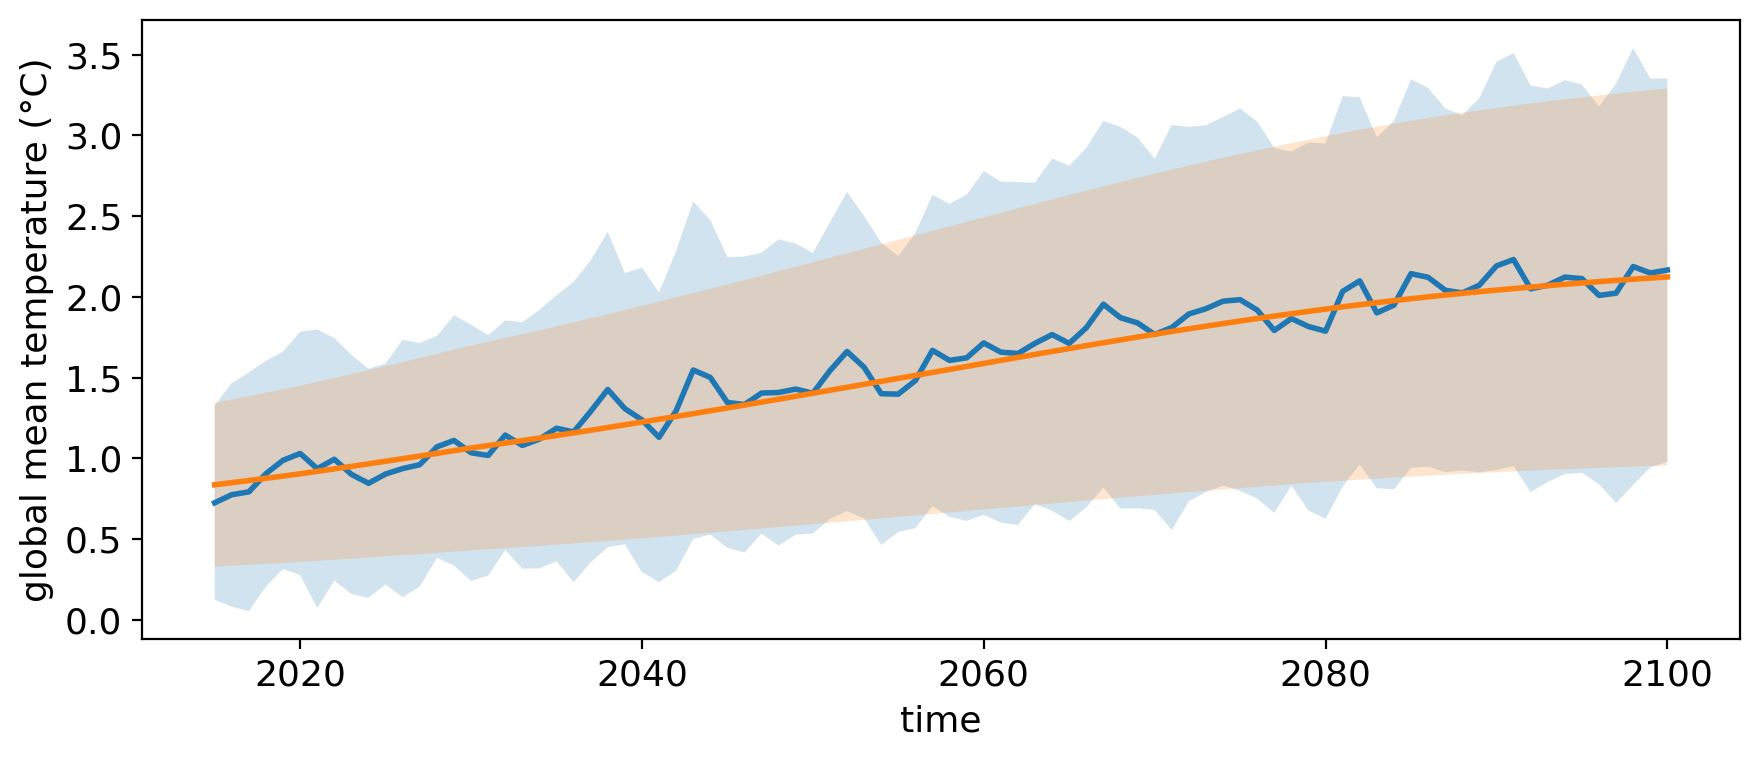

In [24]:
fig,ax = plt.subplots(figsize=(9,4))

global_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_pre,label='prediction',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('global mean temperature (°C)')
plt.tight_layout()

In [25]:
print(y_test_pre)

<xarray.Dataset>
Dimensions:    (time: 86, latitude: 96, longitude: 144)
Coordinates:
  * time       (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    tas        (time, latitude, longitude) float32 0.802 0.8299 ... 5.36 4.897


In [26]:
print(y_test_xr)

<xarray.Dataset>
Dimensions:                    (time: 86, latitude: 96, longitude: 144)
Coordinates:
  * latitude                   (latitude) float64 -90.0 -88.11 ... 88.11 90.0
  * longitude                  (longitude) float64 0.0 2.5 5.0 ... 355.0 357.5
  * time                       (time) int64 2015 2016 2017 ... 2098 2099 2100
Data variables:
    diurnal_temperature_range  (time, latitude, longitude) float32 0.09798 .....
    pr                         (time, latitude, longitude) float32 3.614e-07 ...
    pr90                       (time, latitude, longitude) float64 8.739e-07 ...
    tas                        (time, latitude, longitude) float32 1.475 ... ...


In [28]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import xarray as xr



# Accessing the 'tas' variable
tas_dataset1 = y_test_pre['tas'] #predicted values
tas_dataset2 = y_test_xr['tas'] #true values

# Calculate the mean 'tas' per day
mean_tas_dataset1 = tas_dataset1.mean(dim='time')
mean_tas_dataset2 = tas_dataset2.mean(dim='time')

# Convert the xarray DataArray to numpy arrays
mean_tas_array1 = mean_tas_dataset1.values
mean_tas_array2 = mean_tas_dataset2.values

# Flatten the arrays
mean_tas_array1 = mean_tas_array1.flatten()
mean_tas_array2 = mean_tas_array2.flatten()

# Calculate R2 score
r2 = r2_score(mean_tas_array1, mean_tas_array2)
print("R2 score:", r2)

# Calculate MSE
mse = mean_squared_error(mean_tas_array1, mean_tas_array2)
print("MSE:", mse)


R2 score: 0.9687915121534469
MSE: 0.04378145
